# Anomally Generative Adversarian Network (AnoGAN)

In [1]:
from __future__ import print_function

import matplotlib
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import argparse
import anogan

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


In [2]:
### 0. prepare data

# seed for reproducibility
SEED = 44000

# lists to store data
data = []
label = []

# folder where data is placed
BASE_FOLDER = '/floyd/input/tomato_dataset/'
folders = os.listdir(BASE_FOLDER)

# loading data to lists
for folder in folders:
    for file in os.listdir(BASE_FOLDER + folder + '/'):
        img = cv2.imread(BASE_FOLDER + folder + '/' + file)
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_NEAREST)
        img = img.astype(np.float32) / 255.0
        data.append(img)
        label.append(folder)

# now split the data in to train and test with the help of train_test_split
X_train, X_test, _, _ = train_test_split(data, label, test_size=0.2, random_state=SEED)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

X_test_original = X_test.copy()

print ('train shape:', X_train.shape)

train shape: (153216, 48, 48, 3)


In [3]:
Model_d, Model_g = anogan.train(64, X_train)

Epoch is 0
2393/2394 [============================>.] - ETA: 0s - g: 0.1208 - d: 0.1071
Epoch is 1
2393/2394 [============================>.] - ETA: 0s - g: 0.1224 - d: 0.0783
Epoch is 2
2393/2394 [============================>.] - ETA: 0s - g: 0.1933 - d: 0.0932
Epoch is 3
2393/2394 [============================>.] - ETA: 0s - g: 0.1914 - d: 0.0934
Epoch is 4
2393/2394 [============================>.] - ETA: 0s - g: 0.1560 - d: 0.0844
Epoch is 5
2393/2394 [============================>.] - ETA: 0s - g: 0.2096 - d: 0.0958
Epoch is 6
2393/2394 [============================>.] - ETA: 0s - g: 0.2110 - d: 0.0919
Epoch is 7
2393/2394 [============================>.] - ETA: 0s - g: 0.2388 - d: 0.0905
Epoch is 8
2393/2394 [============================>.] - ETA: 0s - g: 0.2737 - d: 0.0993
Epoch is 9
2393/2394 [============================>.] - ETA: 0s - g: 0.3179 - d: 0.1028
Epoch is 10
2393/2394 [============================>.] - ETA: 0s - g: 0.3843 - d: 0.1108
Epoch is 11
2393/2394 [========

In [4]:
### 2. test generator
generated_img = anogan.generate(36)
img = anogan.combine_images(generated_img)
img = img*255.0
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

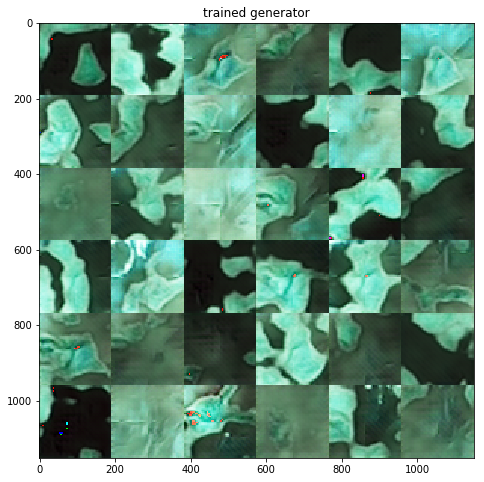

In [5]:
### plt view
plt.figure(num=0, figsize=(8, 8))
plt.title('trained generator')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [15]:
### 3. other class anomaly detection

def anomaly_detection(test_img, g=None, d=None):
    model = anogan.anomaly_detector(g=g, d=d)
    ano_score, similar_img = anogan.compute_anomaly_score(model, test_img.reshape(1, 48, 48, 3), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(48,48,3) - similar_img.reshape(48,48,3)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(48,48,3)*255).astype(np.uint8)
    similar_x = (similar_img.reshape(48,48,3)*255).astype(np.uint8)
    
    #original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

In [4]:
def anomaly_evaluation(test_img):
    start = cv2.getTickCount()
    score, qurey, pred, diff = anomaly_detection(test_img)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    
    ## matplot view
    plt.figure(1, figsize=(3, 3))
    plt.title('query image')
    plt.imshow(qurey.reshape(48,48,3), cmap=plt.cm.gray)

    print("anomaly score : ", score)
    plt.figure(2, figsize=(3, 3))
    plt.title('generated similar image')
    plt.imshow(pred.reshape(48,48,3), cmap=plt.cm.gray)
    
    plt.figure(3, figsize=(3, 3))
    plt.title('anomaly detection')
    plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
    plt.show()

anomaly score :  978.9766235351562


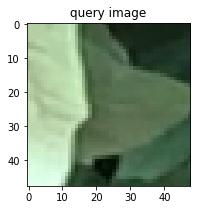

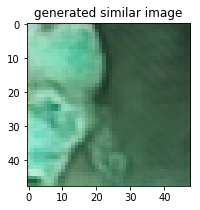

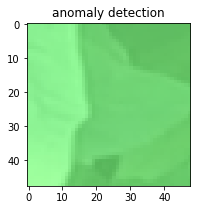

In [14]:
### compute anomaly score - sample from test set
test_img = X_test_original[126]
anomaly_evaluation(np.array([test_img]))

random noise image
100/100 [==============================] - 0s 262us/step


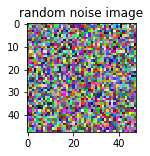

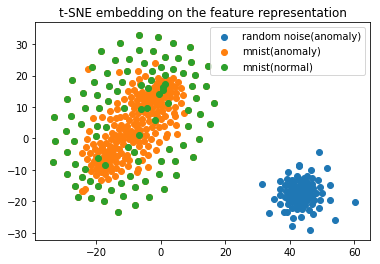

In [16]:
### 4. tsne feature view

### t-SNE embedding 
### generating anomaly image for test (radom noise image)

from sklearn.manifold import TSNE

random_image = np.random.uniform(0, 1, (100, 48, 48, 3))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(48,48,3), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = anogan.feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[:300], verbose=1)
feature_map_of_minist_1 = model.predict(X_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()